In [2]:
# Charger les packages nécessaires
install.packages("tidyverse")
library(tidyverse)  # Contient dplyr, tidyr, ggplot2, etc.
library(readr)

Installation du package dans 'C:/Users/Nesserine/AppData/Local/R/win-library/4.4'
(car 'lib' n'est pas spécifié)



le package 'tidyverse' a été décompressé et les sommes MD5 ont été vérifiées avec succés

Les packages binaires téléchargés sont dans
	C:\Users\Nesserine\AppData\Local\Temp\RtmpaeRd9m\downloaded_packages


── Attaching core tidyverse packages ───────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ─────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
# Importer les données (à remplacer par le chemin du fichier réel)
# Assumons que le fichier est un CSV nommé "portfolio_data.csv"
data <- read_csv("portfolio_data.csv")

Rows: 19554 Columns: 3
── Column specification ─────────────────────────────────────────
Delimiter: ","
chr (1): Gender
dbl (2): SAR, FinalRate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# Résumé des données   tu  peux utiliser (glimpse(data)  # Permet de voir les types de colonnes et un aperçu rapide)
summary(data)

# Vérifier les types de données
str(data)

    Gender               SAR            FinalRate       
 Length:19554       Min.   : 110121   Min.   :0.000086  
 Class :character   1st Qu.: 568401   1st Qu.:0.000196  
 Mode  :character   Median : 825000   Median :0.000341  
                    Mean   : 900263   Mean   :0.000811  
                    3rd Qu.:1241900   3rd Qu.:0.000576  
                    Max.   :4180000   Max.   :3.500000  
                    NA's   :3         NA's   :2         

spc_tbl_ [19,554 × 3] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ Gender   : chr [1:19554] "Female" "Male" "Male" "Male" ...
 $ SAR      : num [1:19554] 990000 1551000 1078000 649000 1121706 ...
 $ FinalRate: num [1:19554] 0.000113 0.000765 0.000181 0.00021 0.000326 ...
 - attr(*, "spec")=
  .. cols(
  ..   Gender = col_character(),
  ..   SAR = col_double(),
  ..   FinalRate = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


### Étape 1 : Nettoyage de base des données

In [5]:


# Vérifier les valeurs manquantes
missing_values <- data %>%
  summarise_all(~ sum(is.na(.)))

print(missing_values)  # Affiche le nombre de valeurs manquantes par colonne



# A tibble: 1 × 3
  Gender   SAR FinalRate
   <int> <int>     <int>
1      2     3         2


In [6]:
#ici j'ai 2 valeurs manquantes pour Gender, 3 valeurs manquantes pour SAR et 2 valeurs manquantes pour Final rate

In [7]:
# Suppression des lignes avec des valeurs manquantes (s'il y en a peu) 
# ou imputation des valeurs manquantes (s'il y en a beaucoup)
data_clean <- data %>%
  drop_na()  # Suppression des lignes avec NA (peut être ajusté selon les besoins)


### Étape 2 : Vérification et correction des types de données

In [8]:
# Vérifier les types de données
#str(data_clean)

# S'assurer que 'Gender' est un facteur (catégorielle)
data_clean <- data_clean %>%
  mutate(Gender = as.factor(Gender))

# Uniformiser les valeurs de 'Gender'
data_clean <- data_clean %>%
  mutate(Gender = recode(Gender,
                          "Famale" = "Female",  # Correction de "Famale" à "Female"
                          "Unknown" = NA_character_))  # Remplacement de "Unknown" par NA

# Vérifier les niveaux de la variable 'Gender'
levels(data_clean$Gender)

[1] "Female" "Male"

In [9]:
# Vérifier les valeurs uniques après correction
unique(data_clean$Gender)

[1] Female Male   <NA>  
Levels: Female Male

In [19]:
# Suppression des lignes spécifiques
data_clean <- data_clean %>%
  filter(!(Gender == 'Male' & SAR == 1387474 & FinalRate == '01.févr' |
           Gender == 'Unknown' & SAR == 367400 & FinalRate == '03.mai' |
           Gender == 'Male' & SAR == 605000 & FinalRate == 'janv.38'))

# Affichage du DataFrame filtré
print(data_clean)

# A tibble: 19,547 × 3
   Gender      SAR FinalRate
   <fct>     <dbl>     <dbl>
 1 Female  990000   0.000113
 2 Male   1551000   0.000765
 3 Male   1078000   0.000181
 4 Male    649000   0.000210
 5 Male   1121706.  0.000326
 6 Male   1034000   0.000212
 7 Female  814000   0.000145
 8 Male   1551000   0.000490
 9 Male   1551000   0.000946
10 Male   1291540.  0.00149 
# ℹ 19,537 more rows


In [20]:
# S'assurer que 'Sum At Risk' et 'FinalRate' sont des numériques
data_clean <- data_clean %>%
  mutate(SAR = as.numeric(SAR),
         FinalRate = as.numeric(FinalRate))

### Étape 3 : Identification et traitement des valeurs aberrantes (outliers)

#### Visualization of variables 

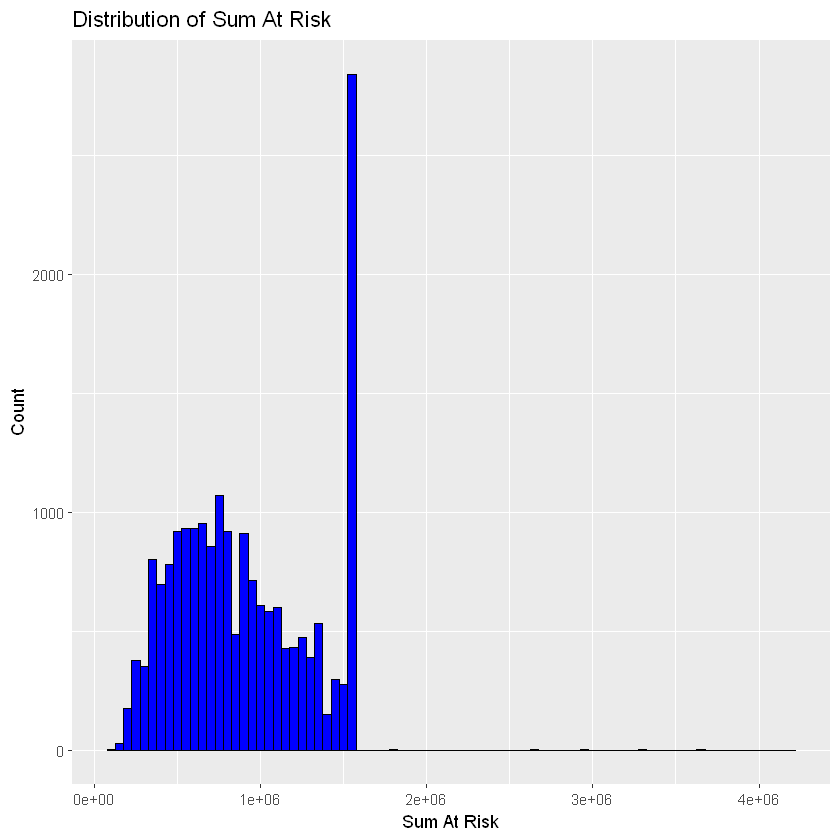

In [22]:
# Visualiser la distribution de 'SAR' pour détecter des outliers
ggplot(data_clean, aes(x = SAR)) +
  geom_histogram(binwidth = 50000, fill = "blue", color = "black") +
  labs(title = "Distribution of Sum At Risk", x = "Sum At Risk", y = "Count")

# Suppression ou traitement des outliers (optionnel, selon l'analyse)
# Exemple : Filtrer les valeurs extrêmement élevées (au-delà d'un certain seuil)
#data_clean <- data_clean %>%
#  filter(SAR < quantile(SAR, 0.99))  # Garde 99% des valeurs les plus basses

Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_bin()`)."


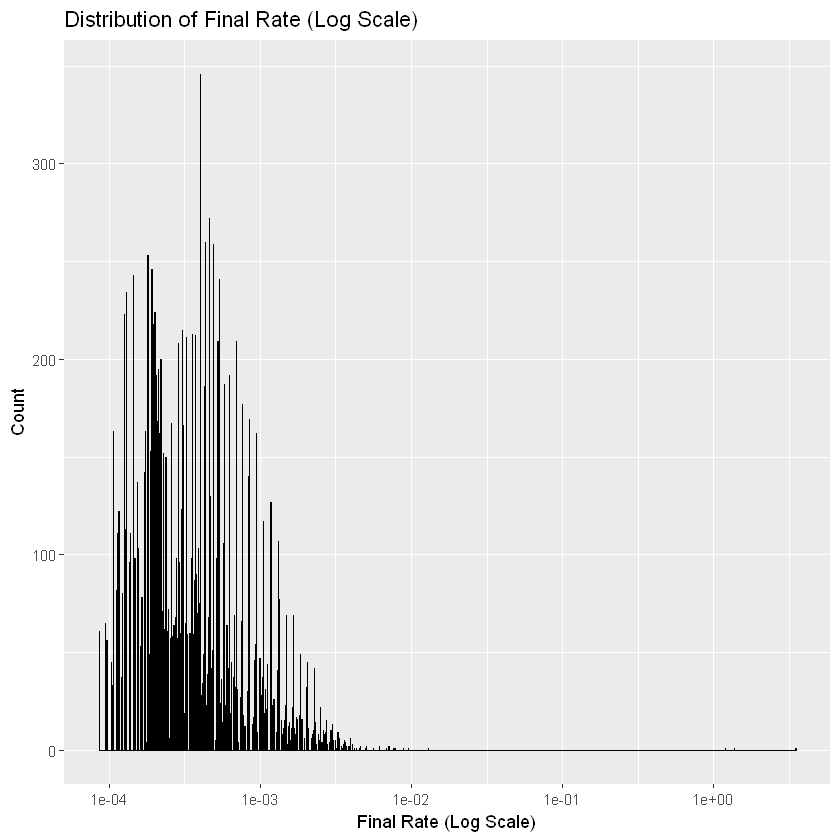

In [23]:
ggplot(data, aes(x = FinalRate)) +
  geom_histogram(binwidth = 0.001, fill = "green", color = "black") +
  scale_x_log10() +
  labs(title = "Distribution of Final Rate (Log Scale)", x = "Final Rate (Log Scale)", y = "Count")


### To detect outliers for SAR column

In [24]:
# Détecter les outliers dans 'SAR'
Q1_SAR <- quantile(data_clean$SAR, 0.25)
Q3_SAR <- quantile(data_clean$SAR, 0.75)
IQR_SAR <- IQR(data_clean$SAR) #to compute Interquartile Range  (IQR) this method is non parametric we don't care about distribution for the data, c'est robust vis a vis skewed data and lest sensitive to extreme data.
# we don't know if values follow normal distribution
lower_bound_SAR <- Q1_SAR - 1.5 * IQR_SAR #le premier quartile minus 1.5*l'interquartile
upper_bound_SAR <- Q3_SAR + 1.5 * IQR_SAR #le troisieme quartile minus 1.5*l'interquartile

outliers_SAR <- data_clean[data_clean$SAR < lower_bound_SAR | data_clean$SAR > upper_bound_SAR, ]
#ici on selctionne les lignes qui sont soit au dessus de l'upper bound ou soit en dessous du lower bound
print(outliers_SAR)

# A tibble: 12 × 3
   Gender     SAR FinalRate
   <fct>    <dbl>     <dbl>
 1 Female 2970000   0.00170
 2 Female 3300000   0.00144
 3 Male   3630000   0.00205
 4 Male   2970000   0.00275
 5 Male   2640000   0.00205
 6 Male   3630000   0.00166
 7 Male   3630000   0.00501
 8 Male   2640000   0.00166
 9 Male   2970000   0.00205
10 Male   4180000   0.00228
11 Male   3300000   0.00950
12 NA     2256000   0.00302


### To detect outliers for Finalrate column

In [25]:
# Détecter les outliers dans 'FinalRate'
Q1_FinalRate <- quantile(data_clean$FinalRate, 0.25)
Q3_FinalRate <- quantile(data_clean$FinalRate, 0.75)
IQR_FinalRate <- IQR(data_clean$FinalRate) #to compute Interquartile Range (IQR)
lower_bound_FinalRate <- Q1_FinalRate - 1.5 * IQR_FinalRate #le premier quartile minus 1.5*l'interquartile
upper_bound_FinalRate <- Q3_FinalRate + 1.5 * IQR_FinalRate #le troisieme quartile minus 1.5*l'interquartile

outliers_FinalRate <- data_clean[data_clean$FinalRate < lower_bound_FinalRate | data_clean$FinalRate > upper_bound_FinalRate, ]
print(outliers_FinalRate)

# A tibble: 1,748 × 3
   Gender      SAR FinalRate
   <fct>     <dbl>     <dbl>
 1 Male   1291540.   0.00149
 2 Male   1551000    0.00205
 3 Female 1540000    0.00120
 4 Male   1551000    0.00205
 5 Male   1551000    0.00118
 6 Male   1551000    0.00331
 7 Female 2970000    0.00170
 8 Male   1024650    0.00185
 9 Female 1551000    0.00265
10 Male   1551000    0.00118
# ℹ 1,738 more rows


### Replace outliers in SAR/FinalRate column by MEDIAN Value

In [26]:
# Remplacer les outliers dans 'SAR' par la médiane
median_SAR <- median(data_clean$SAR, na.rm = TRUE)
data_clean <- data_clean %>%
  mutate(SAR = ifelse(SAR < lower_bound_SAR | SAR > upper_bound_SAR, median_SAR, SAR))

# Remplacer les outliers dans 'FinalRate' par la médiane
median_FinalRate <- median(data_clean$FinalRate, na.rm = TRUE)
data_clean <- data_clean %>%
  mutate(FinalRate = ifelse(FinalRate < lower_bound_FinalRate | FinalRate > upper_bound_FinalRate, median_FinalRate, FinalRate))

### To visualize data we cleaned

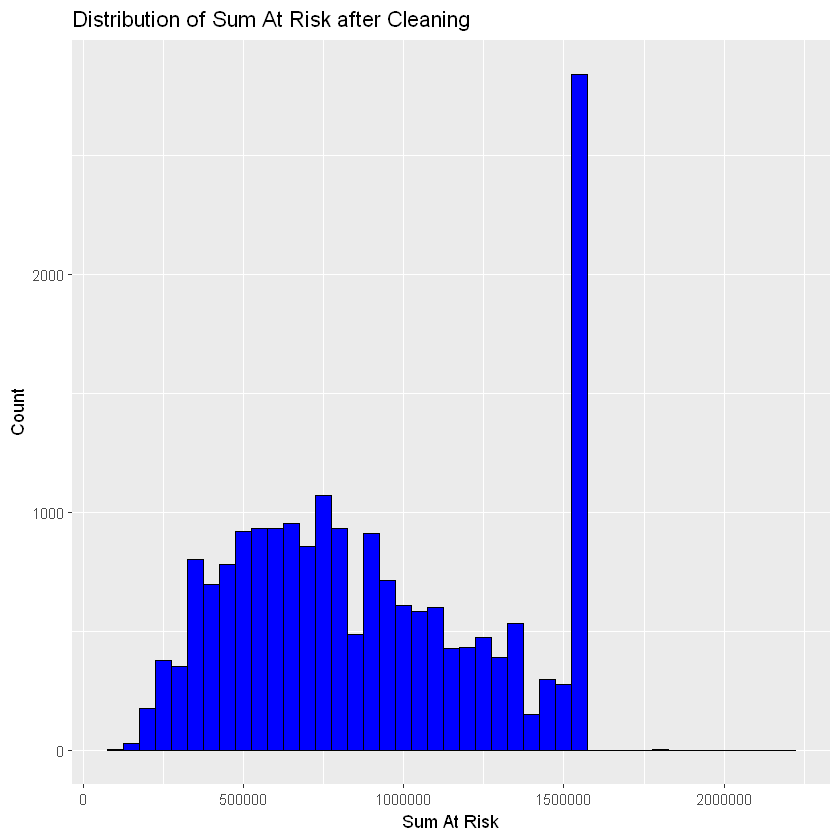

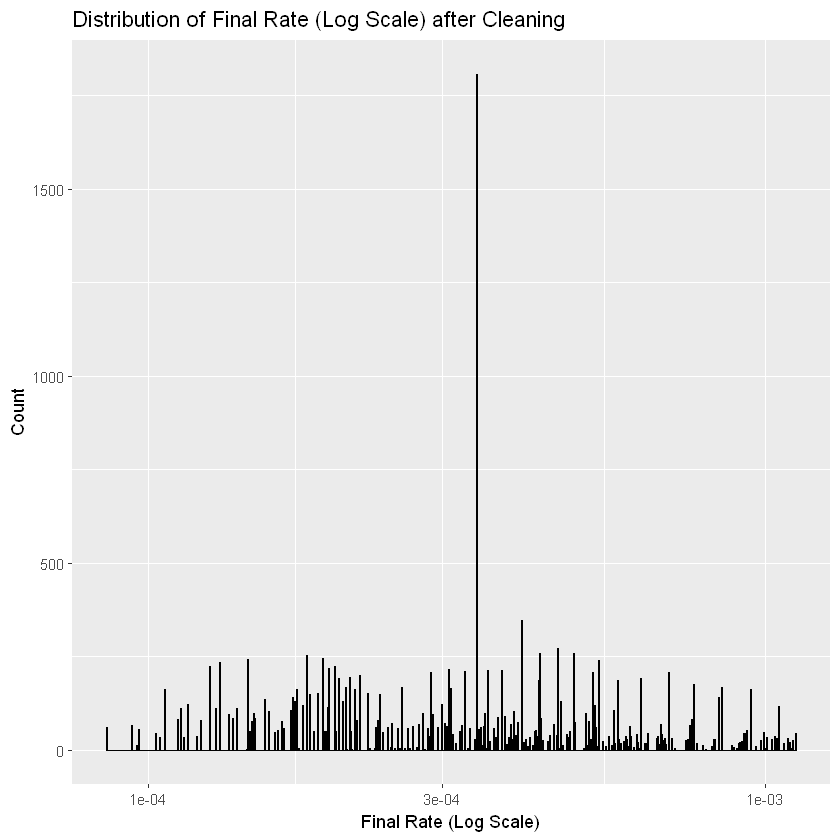

In [29]:
# Visualiser la distribution de 'SAR' après nettoyage
ggplot(data_clean, aes(x = SAR)) +
  geom_histogram(binwidth = 50000, fill = "blue", color = "black") +
  labs(title = "Distribution of Sum At Risk after Cleaning", x = "Sum At Risk", y = "Count")

# Visualiser la distribution de 'FinalRate' après nettoyage
ggplot(data_clean, aes(x = FinalRate)) +
  geom_histogram(binwidth = 0.001, fill = "green", color = "black") +
  scale_x_log10() +
  labs(title = "Distribution of Final Rate (Log Scale) after Cleaning", x = "Final Rate (Log Scale)", y = "Count")

In [30]:
# Documenter les changements et les hypothèses
cat("Changes made to the data:\n")
cat("1. Removed rows with missing values.\n")
cat("2. Detected and replaced outliers in 'SAR' and 'FinalRate' using the IQR method.\n")
cat("3. Replaced outliers with the median value of the respective column.\n")

cat("\nPotential impact of assumptions:\n")
cat("1. Removing rows with missing values may reduce the sample size but ensures data completeness.\n")
cat("2. Replacing outliers with the median value helps to mitigate the impact of extreme values on the analysis.\n")
cat("3. The IQR method is robust to outliers and is suitable for non-normally distributed data.\n")

Changes made to the data:
1. Removed rows with missing values.
2. Detected and replaced outliers in 'SAR' and 'FinalRate' using the IQR method.
3. Replaced outliers with the median value of the respective column.

Potential impact of assumptions:
1. Removing rows with missing values may reduce the sample size but ensures data completeness.
2. Replacing outliers with the median value helps to mitigate the impact of extreme values on the analysis.
3. The IQR method is robust to outliers and is suitable for non-normally distributed data.


In [32]:
# Générer un fichier CSV pour le DataFrame data_clean
write.csv(data_clean, file = "portfolio_data_clean_ness.csv", row.names = FALSE)